# Note: in markdown cells, It's probably easiest to leave any notes we intend to remove before submission with red text or something along those lines. That way, we can easily find them later and remove them before submitting. 

Red text can be added in markdown cells with the following syntax: \<font color='red'\>text\</font\> (replace 'text' with the text you want to be red). It'll look like this: <font color='red'>text</font>


### AST 5731 
#### Group 3 - Project 2
#### Group Members: Thomas Atkins, Tyler Barna, Tore Boybei, and Haowen Zhong

#### Contents

<font color='red'> the hyperlinks won't work when viewing the notebook on github, but they should work when viewing the notebook on jupyter notebook or when exported as an html file </font>

<font color='red'>some of these sections may not be necessary/some more may be needed</font>

 1. [Introduction](#introduction)
 2. [Data](#data)  
    2.1 [Importing Data](#importing-data)    
    2.2 [Data Visualization](#visualization)
 3. [Analysis](#analysis)   
    3.1 [Components of Statistical Model](#model)  
    3.2 [Prior Predictive Check](#prior)     
    3.3 [Posterior](#posterior)     
    3.4 [Sensitivity Analysis](#senstivity)
 4. [Results](#results)

### 1. Introduction 
<a id='introduction'></a>

### 2. Data
<a id='data'></a>

Note: Our project was run on python 3.9.13, and an environment package detailing the versions for all packages used can be found [here](https://github.com/tylerbarna/AST5731-projects/blob/main/environment.yml).

Importing packages used for project: 

<font color='red'> not all of these may end up being needed, can remove stray packages at end</font>

In [32]:
import csv
import dis
import inspect
import os
import sys
import time

import astropy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as mc
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
import arviz as az
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from IPython.display import display_html
from IPython.display import Image

from numpy import interp

from scipy import integrate
from scipy import linalg as la
from scipy import optimize

from scipy.stats import beta
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import multivariate_normal as mvn
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform

from sklearn import preprocessing as pp

%matplotlib inline
plt.style.use("seaborn-colorblind")
mpl.rcParams.update({"axes.grid" : False})
plt.style.context(("seaborn-colorblind",))

## set seed for reproducibility
random.seed(5731)

#### 2.1 Importing Data
<a id='importing'></a>  

In [3]:
df = pd.read_csv('dat.txt',index_col=0,
                 dtype={'Galaxy':str, 'Type':str,
                        'N_GC':np.float64, 'N_GC_err':np.float64,
                        'Mdyn':np.float64, 'MBH':np.float64,
                        'sig_e':np.float64, 'err_sig_e':np.float64,
                        'A_V':np.float64, 'MV_T':np.float64,
                        'err_MV_T':np.float64, 'MK':np.float64,
                        'Re':np.float64, 'upMBH':np.float64,
                        'lowMBH':np.float64
                        })
df.rename({'err_sig_e':'sig_e_err', 'err_MV_T':'MV_T_err'}, axis=1, inplace=True) ## for consistency
display(df.head())
display(df.describe())

for type in df['Type'].unique():
    print('Number of {} Galaxies: {}'.format(type,len(df[df['Type']==type])))

,Galaxy,Type,N_GC,N_GC_err,Mdyn,MBH,sig_e,sig_e_err,A_V,MV_T,MV_T_err,MK,Re,upMBH,lowMBH
1,MilkyWay,S,160.0,10.0,9.856,6.61,105.0,20.0,0.000,-21.30,0.30,NaN,0.70,0.04,0.04
2,WLM,Irr,1.0,0.0,NaN,NaN,NaN,NaN,0.088,-14.84,0.20,NaN,NaN,NaN,NaN
3,NGC7814,S,150.0,40.0,10.879,NaN,169.2,7.2,0.147,-20.18,0.28,-23.531,2.84,NaN,NaN
4,NGC55,S,36.0,15.0,NaN,NaN,NaN,NaN,0.036,-18.77,0.20,-20.356,2.31,NaN,NaN
5,NGC147,E,10.0,2.0,8.408,NaN,22.0,5.0,0.475,-15.46,0.30,-17.254,0.57,NaN,NaN


,N_GC,N_GC_err,Mdyn,MBH,sig_e,sig_e_err,A_V,MV_T,MV_T_err,MK,Re,upMBH,lowMBH
count,421.000000,422.000000,256.000000,65.000000,274.000000,274.000000,422.000000,421.000000,421.000000,351.000000,343.000000,65.000000,65.000000
mean,1573.788599,396.078199,10.715344,5.944154,167.854745,7.355839,0.130540,-19.130926,0.236841,17071.801422,4.260933,2.394154,0.117231
std,4181.748799,1435.582276,0.972814,3.923606,93.381261,5.604451,0.202398,2.792806,0.108609,129809.646248,6.072945,3.664595,0.130845
min,0.000000,0.000000,7.693000,0.000000,10.400000,0.700000,0.000000,-24.190000,0.200000,-27.080000,0.130000,0.030000,0.000000
25%,15.000000,6.000000,9.988500,0.000000,85.150000,3.700000,0.052000,-21.310000,0.200000,-24.664000,1.265000,0.090000,0.000000
50%,72.000000,17.000000,10.867500,7.950000,168.100000,5.800000,0.081500,-19.590000,0.200000,-23.126000,2.220000,0.160000,0.090000
75%,660.000000,187.750000,11.406000,8.720000,239.200000,9.675000,0.138500,-16.910000,0.210000,-20.412500,4.540000,6.320000,0.160000
max,32500.000000,20000.000000,12.726000,10.320000,414.000000,46.500000,2.583000,-11.170000,1.440000,999999.000000,55.000000,9.950000,0.620000


Number of S Galaxies: 55
Number of Irr Galaxies: 26
Number of E Galaxies: 247
Number of S0 Galaxies: 94


We filter the data to exclude any observations that are NA for the properties we care about.

In [11]:
for var in ['N_GC', 'Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re']:
    df = df[np.isfinite(df[var])]
    
display(df.head())
display(df.describe())

for type in df['Type'].unique():
    print('Number of {} Galaxies: {}'.format(type,len(df[df['Type']==type])))

,Galaxy,Type,N_GC,N_GC_err,Mdyn,MBH,sig_e,sig_e_err,A_V,MV_T,MV_T_err,MK,Re,upMBH,lowMBH
1,MilkyWay,S,160.0,10.0,9.856,6.61,105.0,20.0,0.000,-21.30,0.30,NaN,0.70,0.04,0.04
7,NGC205,E,11.0,3.0,8.775,0.00,31.2,4.7,0.170,-16.66,0.20,-18.947,0.66,4.58,0.00
8,NGC221,E,0.0,1.0,8.843,6.46,75.0,3.0,0.170,-16.54,0.21,-19.327,0.13,0.08,0.10
9,NGC224,S,450.0,100.0,11.046,8.18,160.0,8.0,0.170,-21.80,0.20,-23.467,4.66,0.20,0.10
11,NGC253,S,90.0,40.0,10.571,7.00,102.6,18.8,0.051,-21.01,0.20,-23.979,3.80,0.30,0.30


,N_GC,N_GC_err,Mdyn,MBH,sig_e,sig_e_err,A_V,MV_T,MV_T_err,MK,Re,upMBH,lowMBH
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,63.000000,64.000000,64.000000,64.000000
mean,2190.375000,441.765625,11.098203,5.901250,214.318750,8.767188,0.124969,-21.238281,0.230000,-24.157333,5.192813,2.429688,0.116562
std,3590.416749,775.597010,0.766121,3.939225,87.919507,4.844996,0.074094,1.459538,0.067917,1.540675,4.227364,3.682261,0.131767
min,0.000000,1.000000,8.775000,0.000000,31.200000,2.900000,0.000000,-23.470000,0.200000,-26.521000,0.130000,0.030000,0.000000
25%,212.250000,44.250000,10.769250,0.000000,159.175000,4.700000,0.073250,-22.255000,0.200000,-25.145000,2.057500,0.087500,0.000000
50%,520.000000,150.000000,11.116000,7.935000,211.000000,8.000000,0.105500,-21.305000,0.200000,-24.125000,3.720000,0.160000,0.085000
75%,2298.250000,500.000000,11.651500,8.725000,257.200000,11.150000,0.169250,-20.792500,0.220000,-23.745000,7.330000,6.335000,0.165000
max,18000.000000,4500.000000,12.354000,10.320000,414.000000,20.000000,0.381000,-16.540000,0.530000,-18.947000,17.380000,9.950000,0.620000


Number of S Galaxies: 8
Number of E Galaxies: 40
Number of S0 Galaxies: 16


#### 2.3 Data Visualization
<a id='visualization'></a>

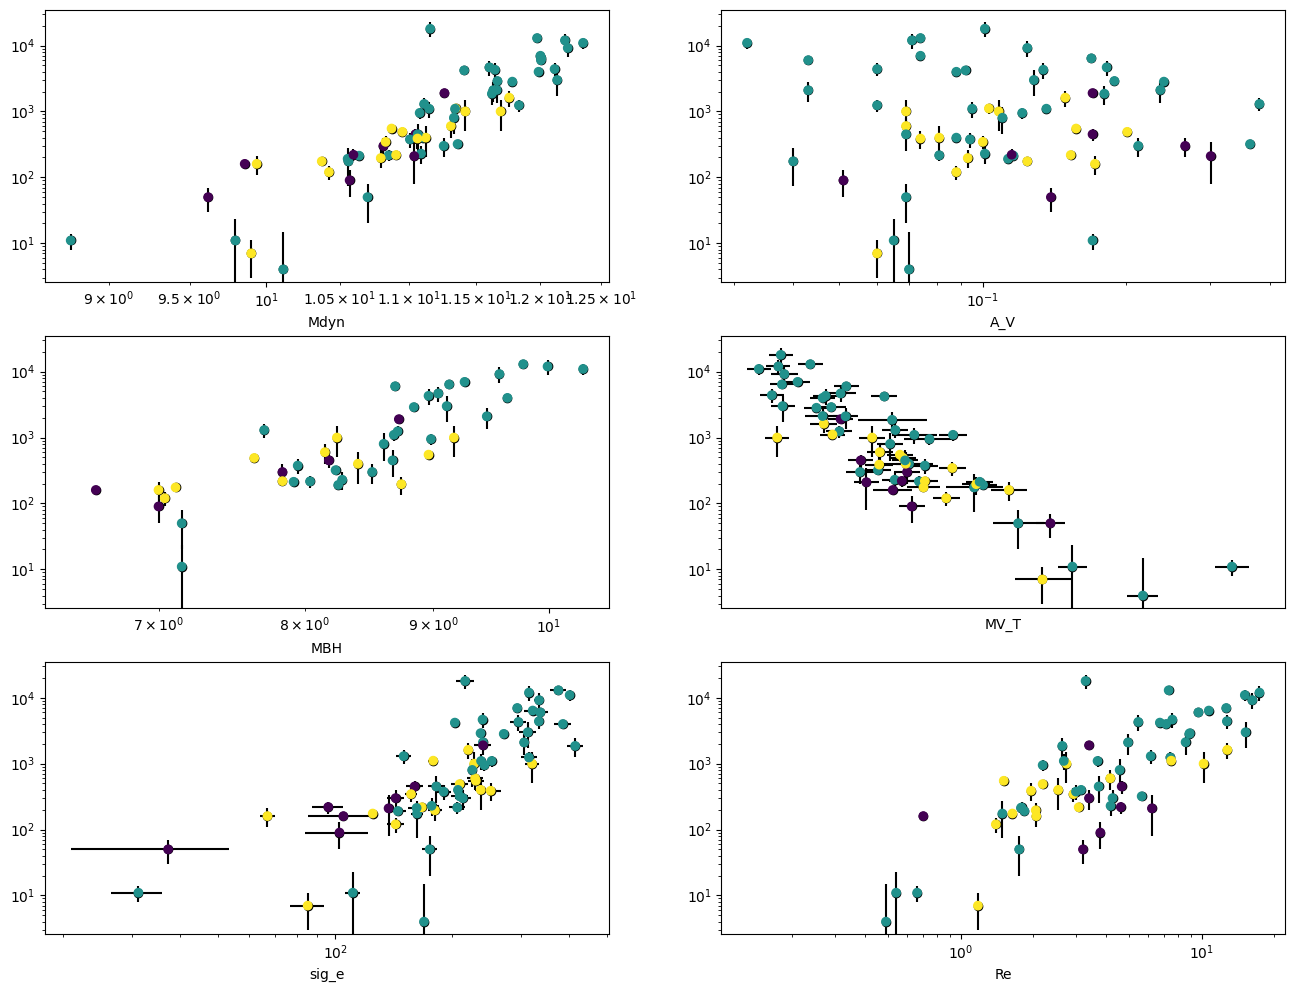

In [69]:
## scatterplot of different variables
def scatterplot(df, var, ax):
    try:
        ax.errorbar(df[var], df['N_GC'], xerr=df[var+'_err'], yerr=df['N_GC_err'], fmt='o', c='black')
    except:
        ax.errorbar(df[var], df['N_GC'], yerr=df['N_GC_err'], fmt='o', c='black')
    ax.scatter(df[var], df['N_GC'], c=df['Type'].factorize()[0], zorder=100)
    avgVar = df[var].mean()
    if avgVar < 0:
        ax.set_xscale('symlog')
    else:
        ax.set_xscale('log')
    ax.set_xlabel(var)
    ax.set_yscale('log')

fig, axs = plt.subplots(3, 2, figsize=(16,12))
vars = ['Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re']
for i, var in enumerate(vars):
    scatterplot(df, var, axs[i%3][i//3])

plt.show()

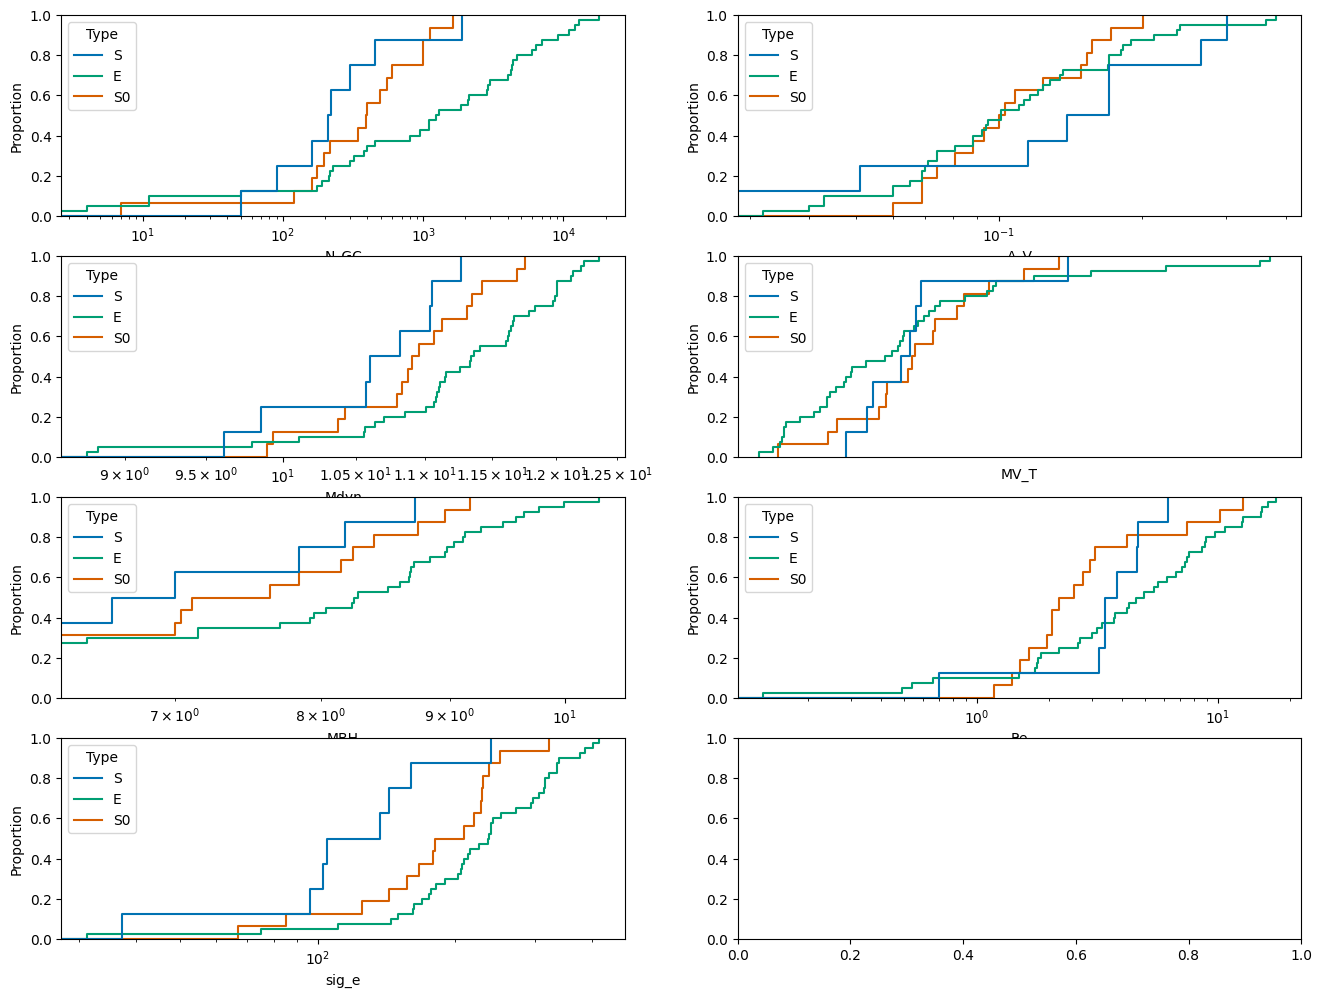

In [70]:
## ECDF plots of different variables
def ecdfplot(df, var, ax):
    plot = sns.ecdfplot(data=df, x=var,  hue='Type',
                       ax=ax)
    avgVar = df[var].mean()
    if avgVar < 0:
        ax.set_xscale('symlog')
        #ax.set_xlim(right=0)
    else:
        ax.set_xscale('log')
    ax.set_xlabel(var)

fig, axs = plt.subplots(4, 2, figsize=(16,12))
vars = ['N_GC', 'Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re']
for i, var in enumerate(vars):
    ecdfplot(df, var, axs[i%4][i//4])
plt.show()

<Figure size 2000x1000 with 0 Axes>

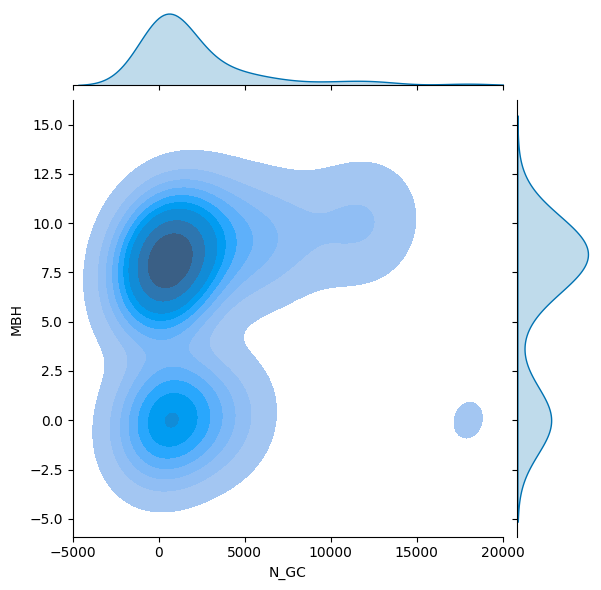

<Figure size 2000x1000 with 0 Axes>

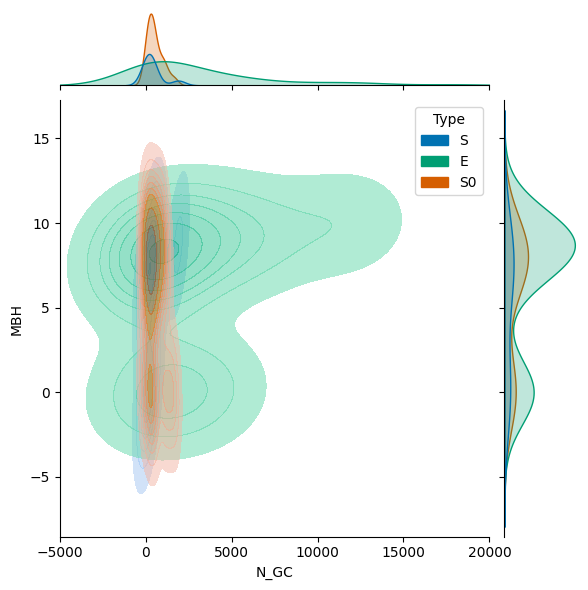

In [71]:
## joint plot of number of globular clusters and mass of black hole
plt.figure(figsize=(20, 10), facecolor='w', edgecolor='k');
plot = sns.jointplot(data=df, x='N_GC',y='MBH',
              kind='kde', fill=True);
plot.ax_marg_x.set_xlim(-5000, 20000);
plt.show();

## joint plot of number of globular clusters and mass of black hole by type
plt.figure(figsize=(20, 10), facecolor='w', edgecolor='k');
plot = sns.jointplot(data=df, x='N_GC',y='MBH', hue='Type',
              kind='kde', fill=True, alpha=0.5);
plot.ax_marg_x.set_xlim(-5000, 20000);
plt.show();

### 3. Bayesian Analysis
<a id='analysis'></a>

#### 3.1 Components of Statistical Model
<a id='model'></a>

Our Poisson regression model is as follows. We incorporate measurement error in both x and y.

$$
Y \sim TruncatedNormal(Y^*, Y_{err}^2, lower=0)\\
Y^* \sim Poisson(e^{X^*\beta})\\
X^*\sim \mathcal{N}(X, X_{err}^2)\\
\beta \sim \mathcal{N}_8(0, 10^3I_8).
$$

We place a wide prior on $\beta$ to allow for many possible regression coefficients.

*Note: in the actual model, including the error terms significantly worsens our ESS, to the point where sampling is infeasible. Therefore, we present our model with measurement error terms, but do not use them.*

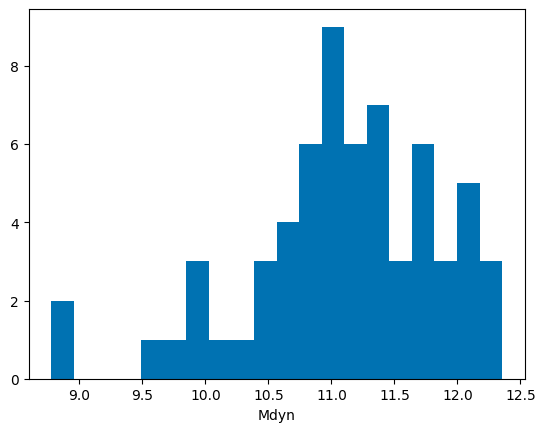

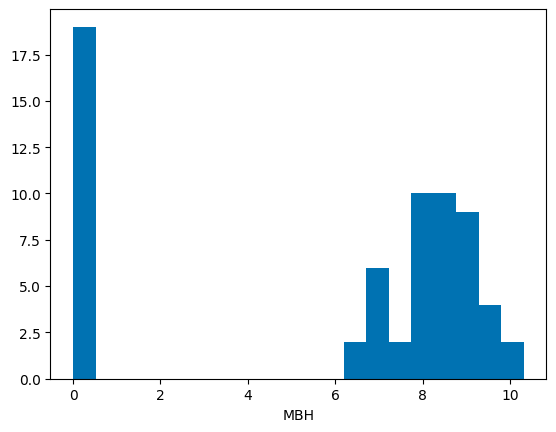

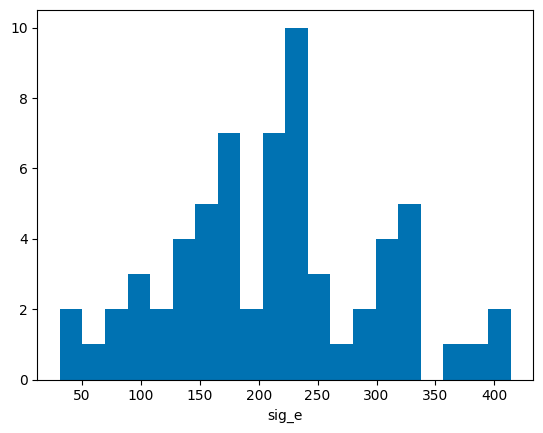

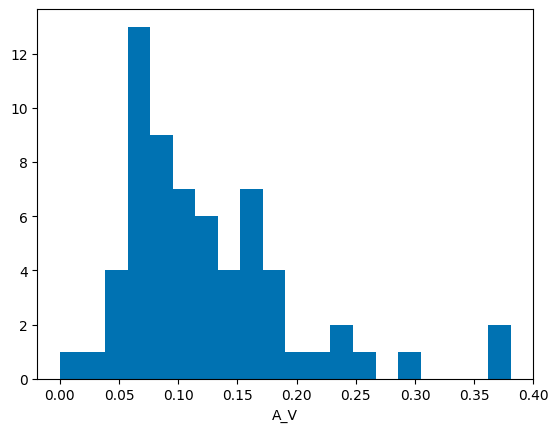

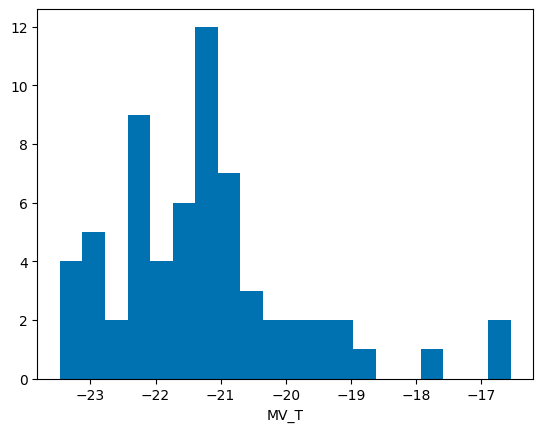

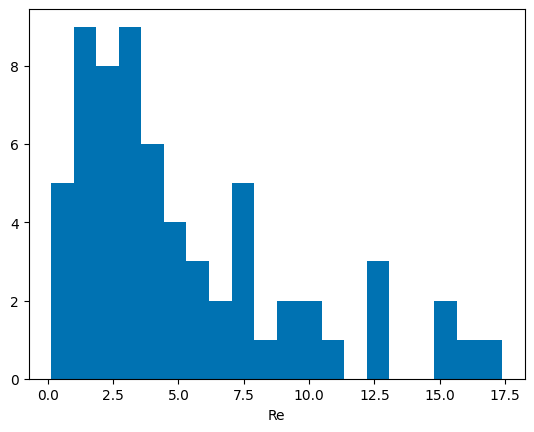

In [132]:
for v in ['Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re']:
    plt.hist(df[v], bins=20)
    plt.xlabel(v)
    plt.show()

In [149]:
# create our data matrix and response vectors

x_vars = ['Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re']

x = np.zeros((len(df), len(x_vars)+3))
x_err = np.zeros((len(df), len(x_vars)+3))
# intercept
x[:, 0] = 1
for i, var in enumerate(x_vars):
    x[:, i+1] = df[var]
    try:
        x_err[:, i+1] = df[var+"_err"]
    except:
        pass

# one-hot enconding of categorical variable
x[:, -2] = df['Type']=='S'
x[:, -1] = df['Type']=='E'

y = df['N_GC']
y_err = df['N_GC_err']

In [119]:
# create model
poisson_log = mc.Model()

with poisson_log:

    beta = mc.Normal('beta', mu=0, tau=1e-2, shape=(x.shape[1],))

    # this line adds measurement error in x
    # in theory,we would add this, but sampling is much, much too slow and our ESS goes way down
    # x_star = mc.Normal('x_star', mu=x, sigma=x_err+1e-10, shape=x.shape)
    x_star = x

    # define linear model and exp link function
    theta = mc.math.dot(x_star, beta)

    ## Define Poisson likelihood
    ystar = mc.Poisson('ystar', mu=np.exp(theta), observed=y)
    # same as above, including error tanks the ESS
    # y_obs = mc.TruncatedNormal('y_obs', mu=ystar, sigma=y_err, lower=0, observed=y)
    trace = mc.sample(draws=1000,return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


ValueError: Not enough samples to build a trace.

#### 3.2 Prior Predicitive Check
<a id='prior'></a>

We perform a prior predictive check with our model to ensure that our data could reasonably be generated by our model.

#### 3.3 Posterior 
<a id='posterior'></a>

In [98]:
summ = az.summary(trace)
summ["name"] = ['Intercept', 'Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re', 'S', "E"]
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,name
beta[0],-4.964,8.712,-20.227,0.903,4.338,3.321,4.0,11.0,3.23,Intercept
beta[1],-0.137,1.083,-1.940,0.856,0.539,0.413,5.0,28.0,3.29,Mdyn
beta[2],-0.190,0.343,-0.783,0.011,0.171,0.131,4.0,15.0,3.16,MBH
beta[3],-0.002,0.017,-0.030,0.012,0.008,0.006,4.0,11.0,3.38,sig_e
beta[4],-0.305,0.898,-1.854,0.520,0.447,0.342,4.0,11.0,3.39,A_V
beta[5],-0.665,0.601,-1.261,0.129,0.299,0.229,4.0,11.0,3.66,MV_T
beta[6],-0.146,0.451,-0.921,0.322,0.224,0.172,4.0,11.0,3.42,Re
beta[7],0.062,0.618,-0.940,0.787,0.308,0.236,4.0,11.0,3.91,S
beta[8],0.644,0.476,-0.055,1.278,0.237,0.181,4.0,17.0,3.39,E


In [95]:
print(f"Minimum ESS: {int(min(az.summary(trace)['ess_bulk']))}")

Minimum ESS: 4


Our minimum ESS looks good, so we proceed with our analysis. We see that the only 94\% HDIs that contain zero are associated with Mdyn and the S indicator variable. We plot the traces below.

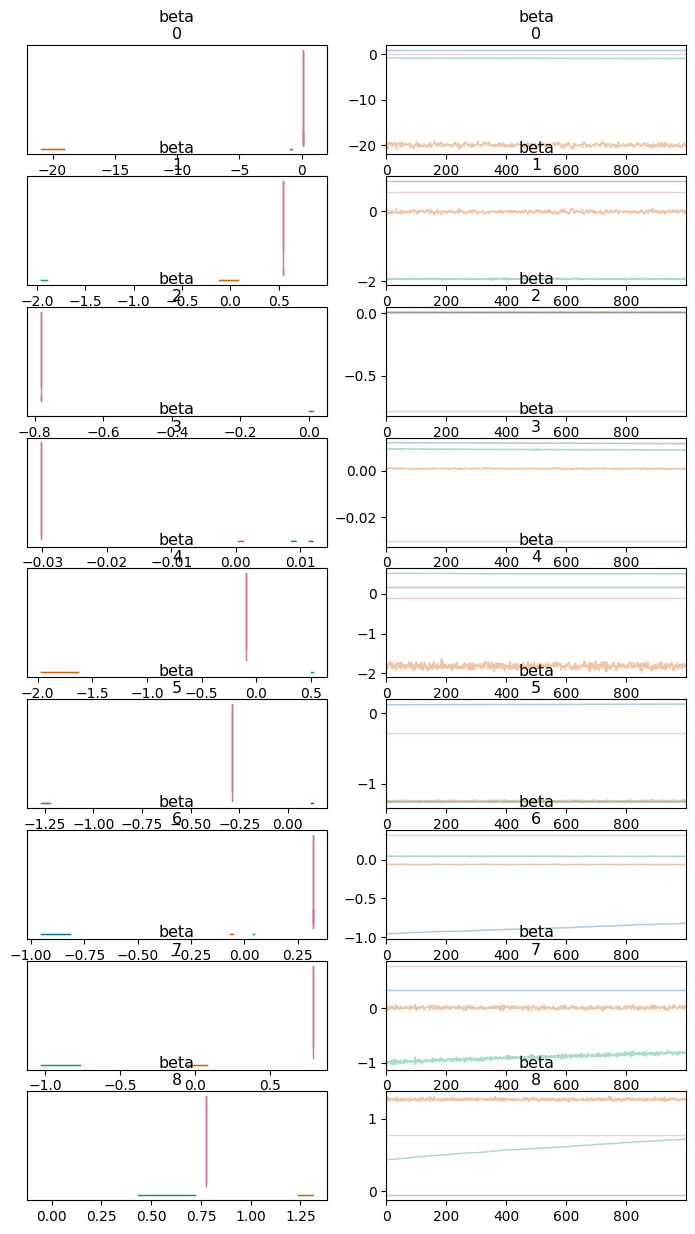

In [96]:
az.plot_trace(trace,var_names=['beta'],figsize=(8.5, 15), compact=False)
plt.show()

array([[<AxesSubplot: title={'center': 'beta\n0'}>,
        <AxesSubplot: title={'center': 'beta\n1'}>,
        <AxesSubplot: title={'center': 'beta\n2'}>],
       [<AxesSubplot: title={'center': 'beta\n3'}>,
        <AxesSubplot: title={'center': 'beta\n4'}>,
        <AxesSubplot: title={'center': 'beta\n5'}>],
       [<AxesSubplot: title={'center': 'beta\n6'}>,
        <AxesSubplot: title={'center': 'beta\n7'}>,
        <AxesSubplot: title={'center': 'beta\n8'}>]], dtype=object)

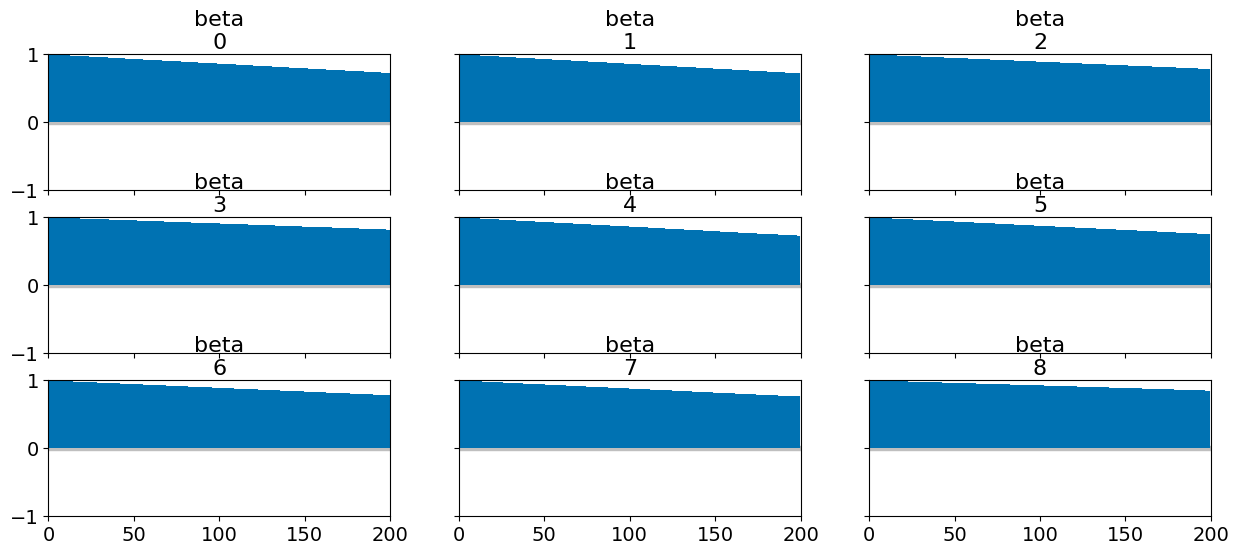

In [97]:
az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200,combined=True,figsize=(15, 6))

#### 3.4 Sensitivity Analysis
<a id='sensitivity'></a>

### 4. Results
<a id='results'></a>